<h1>Importing</h1>

In [1]:
import random
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

import torch
import torch.nn as nn
import torchmetrics
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus": False})

# Set random seeds for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)


Seed set to 1


1

<h1>Data Preparation</h1>

In [2]:
config = {
    "train_data_path": "../datasets/train",
    "val_data_path": "../datasets/val",
    "batch_size": 32,
    "image_size": (224, 224),
}

for path in [config["train_data_path"], config["val_data_path"]]:
    if not Path(path).exists():
        raise FileNotFoundError(f"Path not found: {path}")

train_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=config["train_data_path"], transform=train_transform)
val_dataset = datasets.ImageFolder(root=config["val_data_path"], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

# Temporary for visualization
temp_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.ToTensor(),
])
temp_val_dataset = datasets.ImageFolder(root=config["val_data_path"], transform=temp_transform)
temp_val_loader = DataLoader(temp_val_dataset, batch_size=config["batch_size"], shuffle=True)

<h1>Visualization</h1>

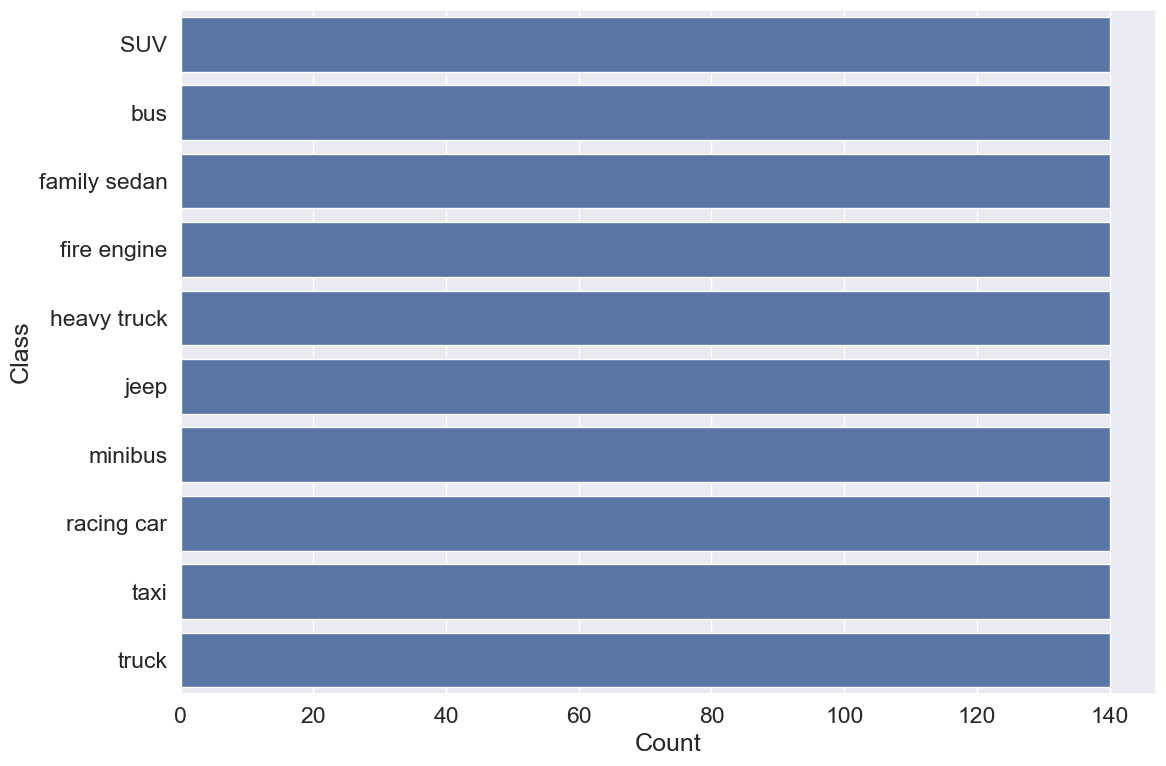

In [3]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

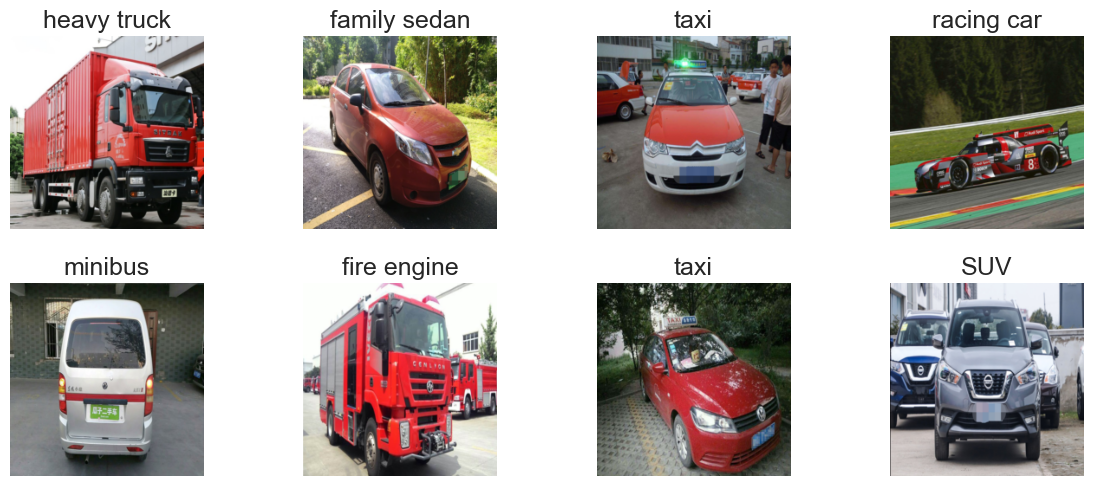

In [4]:
plt.figure(figsize=(12, 20), dpi=100)
images, labels = next(iter(temp_val_loader))
for i in range(8):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()



<h1>Modeling</h1>

In [5]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds



<h5>Train the model or ...</h5>

In [6]:
num_classes = len(class_names)
model = LitModel(num_classes=num_classes)
logger = CSVLogger("../")
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')

trainer = pl.Trainer(
    max_epochs=50,
    enable_progress_bar=True,
    log_every_n_steps=10,
    logger=logger,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | features | Sequential         | 1.6 M  | train
1 | fc       | Sequential         | 2.4 M  | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.763    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 44/44 [00:27<00:00,  1.58it/s, v_num=0]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 44/44 [00:45<00:00,  0.97it/s, v_num=0, val_loss=1.800, val_acc=0.350, train_loss=1.980, train_acc=0.292]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 44/44 [00:46<00:00,  0.96it/s, v_num=0, val_loss=1.390, val_acc=0.545, train_loss=1.560, train_acc=0.465]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 44/44 [00:44<00:00,  1.00it/s, v_num=0, val_loss=1.230, val_acc=0.590, train_loss=1.310, train_acc=0.563]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 44/44 [00:46<00:00,  0.96it/s, v_num=0, val_loss=1.130, val_acc=0.605, train_loss=1.200, train_acc=0.596]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 44/44 [00:44<00:00,  0.99it/s, v_num=0, val_loss=0.988, val_acc=0.675, train_loss=1.060, train_acc=0.636]
Validation: |          | 0/? [00:0

<h5>Load The Trained Model</h5>

In [7]:
checkpoint_path = checkpoint_callback.best_model_path

model = LitModel.load_from_checkpoint(checkpoint_path)

torch.save(model, "vehicle_classifier_customcnn.pt")

In [8]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None
)

trainer.test(model, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9350000023841858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9350000023841858}]

<h1>Predict Test Data</h1>

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s] 


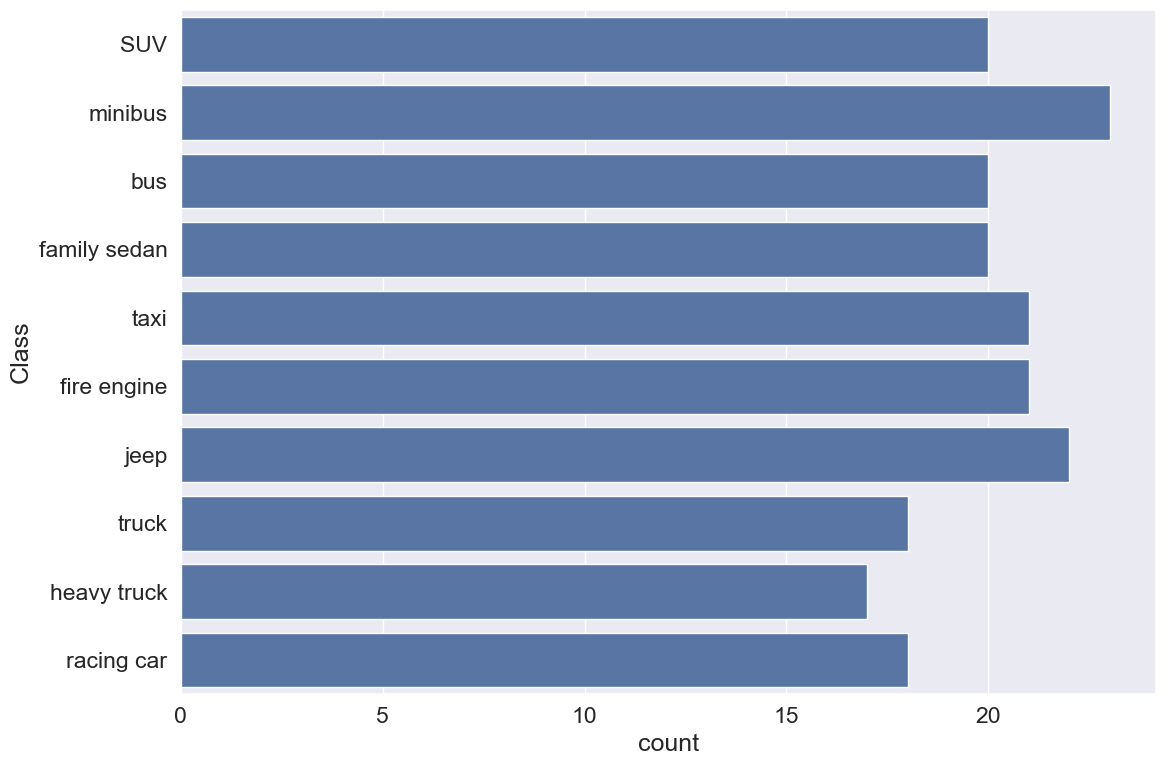

In [9]:
pred = trainer.predict(model, val_loader)
pred = torch.cat(pred, dim=0)
pred = pd.DataFrame(pred.numpy(), columns=["Class"])
pred["Class"] = pred["Class"].apply(lambda x: class_names[x])

plt.figure(figsize=(12, 8), dpi=100)
sns.countplot(y="Class", data=pred)
plt.tight_layout()
plt.show()

<h1>Loss & Accuracy</h1>

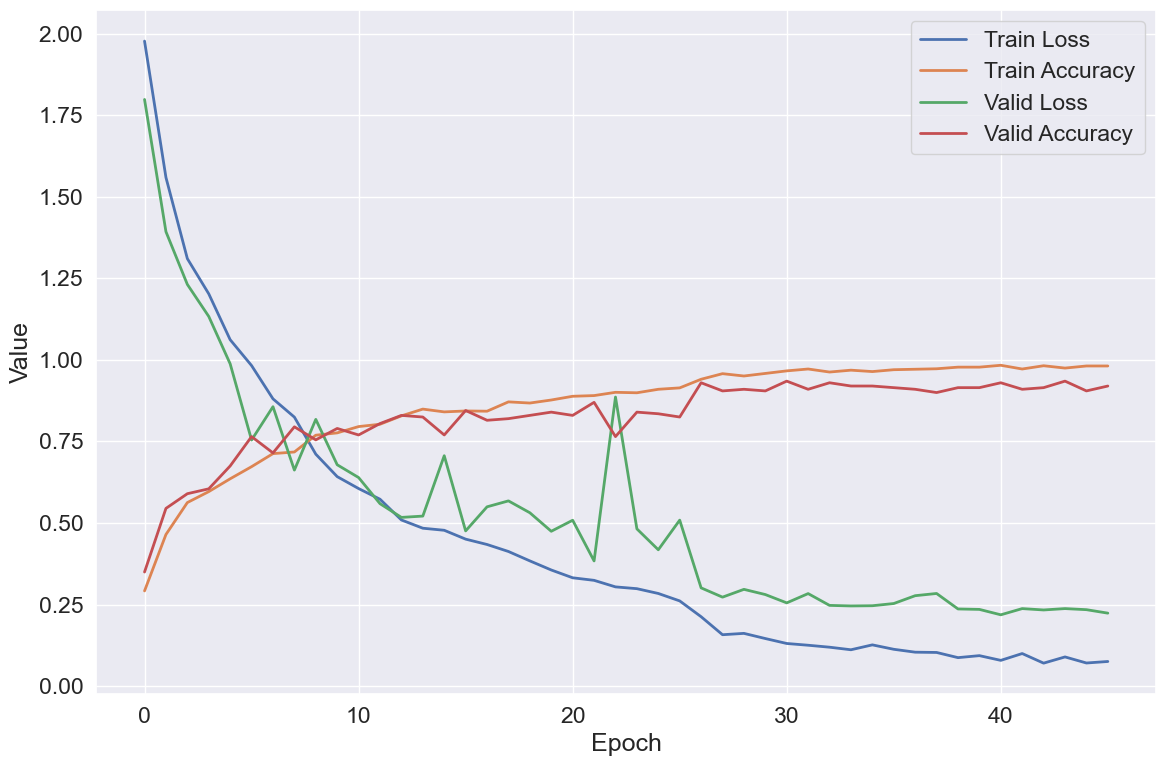

In [10]:
metrics_path = Path(logger.log_dir) / "metrics.csv"
metrics = pd.read_csv(metrics_path)

plt.figure(figsize=(12, 8), dpi=100)
sns.lineplot(x="epoch", y="train_loss", data=metrics, label="Train Loss", linewidth=2)
sns.lineplot(x="epoch", y="train_acc", data=metrics, label="Train Accuracy", linewidth=2)
sns.lineplot(x="epoch", y="val_loss", data=metrics, label="Valid Loss", linewidth=2)
sns.lineplot(x="epoch", y="val_acc", data=metrics, label="Valid Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

<h1>Model Evaluation</h1>

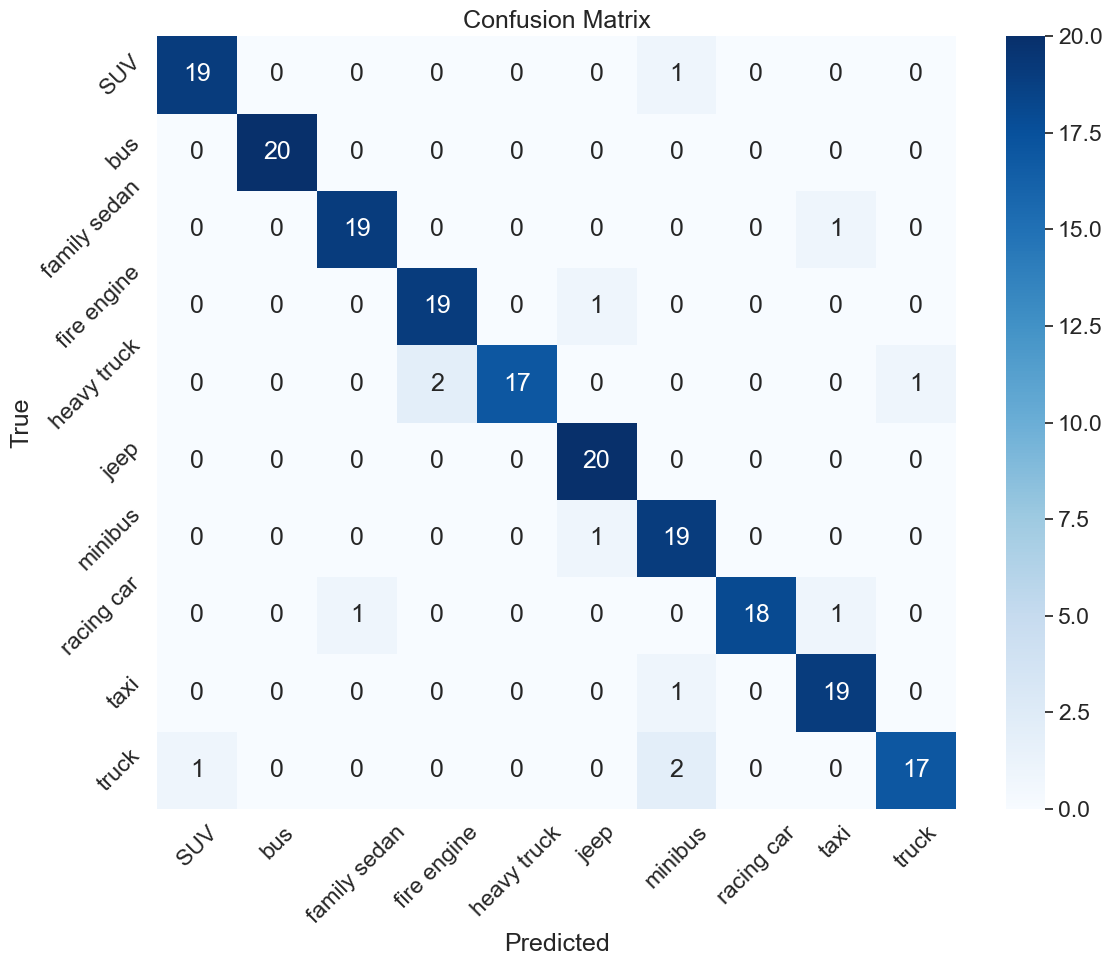


Classification Report:
              precision    recall  f1-score   support

         SUV       0.95      0.95      0.95        20
         bus       1.00      1.00      1.00        20
family sedan       0.95      0.95      0.95        20
 fire engine       0.90      0.95      0.93        20
 heavy truck       1.00      0.85      0.92        20
        jeep       0.91      1.00      0.95        20
     minibus       0.83      0.95      0.88        20
  racing car       1.00      0.90      0.95        20
        taxi       0.90      0.95      0.93        20
       truck       0.94      0.85      0.89        20

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.94       200
weighted avg       0.94      0.94      0.94       200



In [11]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        output = model(x)
        pred = torch.argmax(output, dim=1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(y.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

<h1>Single Image Prediction</h1>

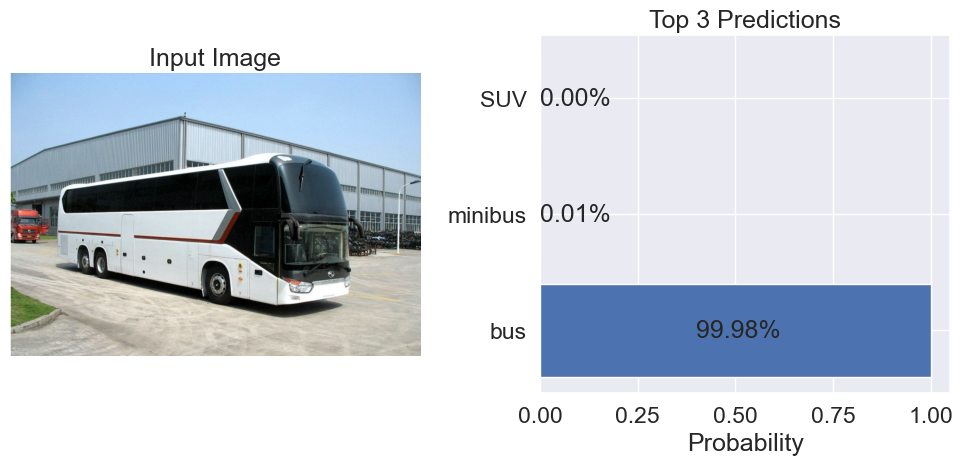

In [12]:
def predict_single_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0]

    top_probs, top_classes = torch.topk(probabilities, k=3)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    plt.subplot(1, 2, 2)
    bars = plt.barh([class_names[i] for i in top_classes], top_probs.cpu().numpy())
    plt.xlabel('Probability')
    plt.title('Top 3 Predictions')

    for bar in bars:
        width = bar.get_width()
        plt.text(width / 2.5, bar.get_y() + bar.get_height() / 2,
                 f'{width:.2%}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

predict_single_image("../datasets/val/bus/1b9471eefb6f3951f127beb69ef5a584.jpg", model, val_transform)